# Stock Price Prediction using Logistic Regression

In [2]:
# Importing the necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tabulate import tabulate

## Definining all the required functions

In [4]:
# Define a function to clean the data by removing unnecessary columns
def clean_data(data):
    """Removes unnecessary columns ('Dividends', 'Volume', 'Stock Splits') from the data."""
    data = data.drop('Dividends', axis=1)
    data = data.drop('Volume', axis=1)
    data = data.drop('Stock Splits', axis=1)
    return data

# Define a function to fetch stock data for a given period
def get_data(ticker, period):
    """
    Fetches historical stock prices and returns cleaned data.

    Args:
        period (str): The time period for fetching stock data. E.g., '1y', '2y', etc.

    Returns:
        pd.DataFrame: Cleaned historical stock prices for Facebook.
    """
    # Fetch data for the given ticker
    get_stock_info = yf.Ticker(ticker)
    
    # Get historical stock data for the given period
    stock_historical = get_stock_info.history(period)
    
    # Clean the data
    stock_historical = clean_data(stock_historical)
    
    return stock_historical

def result_data(data):
    """
    Adds calculated columns to the dataset:
    - 'PercentageChange': The percentage change in the stock's 'Close' price from one period to the next.
    - 'PriceIncrease': A binary flag indicating if the 'PercentageChange' is greater than 2%.

    Args:
        data (pd.DataFrame): The input DataFrame with a 'Close' column representing the stock prices.

    Returns:
        pd.DataFrame: The modified DataFrame with 'PercentageChange' and 'PriceIncrease' columns.
    """
    # Calculate the percentage change in the 'Close' price
    data['PercentageChange'] = data['Close'].pct_change() * 100
    
    # Create a binary column 'PriceIncrease' based on whether the price increased by more than 2%
    data['PriceIncrease'] = (data['PercentageChange'] > 2).astype(int)
    
    return data

def define_data(data):
    """
    Prepares the feature matrix (X) and target vector (y) for model training:
    - Drops unnecessary columns ('Close', 'PercentageChange').
    - Extracts features ('Open', 'High', 'Low') and the target ('PriceIncrease').

    Args:
        data (pd.DataFrame): The input DataFrame with stock data, including 'Open', 'High', 'Low', 'Close'.

    Returns:
        tuple: 
            - x_train (np.ndarray): Feature matrix for training.
            - x_test (np.ndarray): Feature matrix for testing.
            - y_train (np.ndarray): Target vector for training.
            - y_test (np.ndarray): Target vector for testing.
    """
    # Remove the 'Close' and 'PercentageChange' columns, which are not needed for model training
    data = data.drop(['Close', 'PercentageChange'], axis=1)
    
    # Convert the index to datetime format and create a new 'DateTime' column
    data['DateTime'] = pd.to_datetime(data.index)
    
    # Define the target variable (PriceIncrease)
    y = pd.DataFrame(data.pop('PriceIncrease'))
    
    # Define the feature columns ('Open', 'High', 'Low')
    list_of_cols = ["Open", "High", "Low"]
    X = data[list_of_cols]
    
    # Split the data into training and testing sets (80% for training, 20% for testing)
    X_train, X_test, y_train, y_test = train_test_split(X[list_of_cols], y, test_size=0.2)
    
    # Convert the data to numpy arrays for model training
    x_train = np.array(X_train)
    x_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    return x_train, x_test, y_train, y_test

## Execution

In [6]:
# Fetch historical stock data for Facebook (META) for the last 6 months
stock_data = get_data('META', '6mo')

In [7]:
stock_data = result_data(stock_data)
x_train, x_test, y_train, y_test = define_data(stock_data)

In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)

# Train the model using logistic regression
log_reg.fit(x_train, y_train)

# Make predictions on the test set
y_pred = log_reg.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print results
print(f"\033[1mAccuracy\033[0m: {accuracy:.4f}")

print("\033[1mClassification Report:\033[0m")
print(class_report)

Accuracy: 0.8846
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        24
           1       0.00      0.00      0.00         2

    accuracy                           0.88        26
   macro avg       0.46      0.48      0.47        26
weighted avg       0.85      0.88      0.87        26



/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


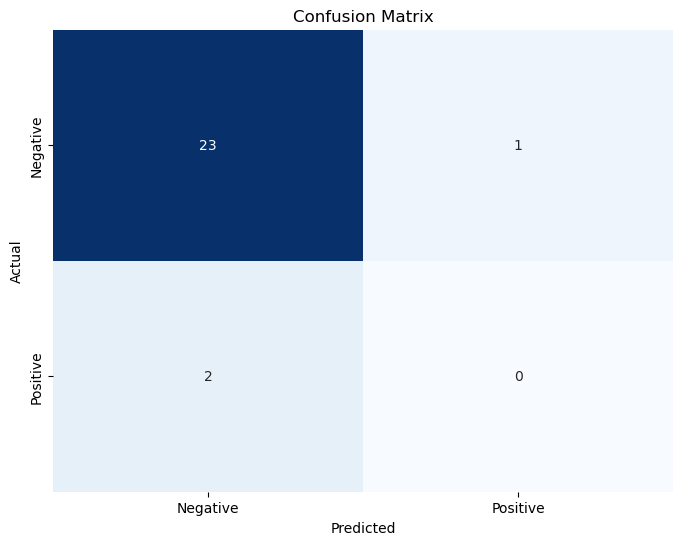

In [9]:
import seaborn as sns

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

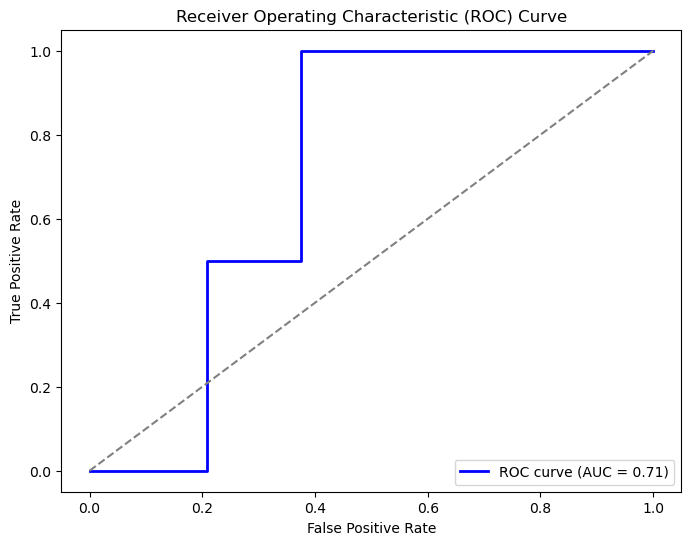

In [10]:
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities for the positive class
y_prob = log_reg.predict_proba(x_test)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()